In [44]:
%config InlineBackend.figure_formats = ['svg']

# What are linear trees?

From [this post](https://towardsdatascience.com/linear-tree-the-perfect-mix-of-linear-model-and-decision-tree-2eaed21936b7):

> Not everybody knows simple yet effective variations of the Decision Tree algorithm. These are known as Model Trees. They learn an optimal splitting of the training data, as in the standard Decision Tree, with the main difference that the **goodness of splits is evaluated fitting models**. A particular case of Model Trees is known as Linear Tree. This implies **having Linear Models in the leaves instead of simple constant approximations**. It can be seen as a simple improvement/alternative from the standard Decision Tree preserving at the same time the interpretation ability.

[**LightGBM**](https://lightgbm.readthedocs.io/en/v3.3.2/) includes the option for linear trees in its implementation, at least for more recent versions.

Using linear trees might allow for better-behaved models in some situations, especially when we want piecewise linear models. Below we show how to use them.

### Some observations

* One must use LightGBM's base API for this, instead of the scikit-learn API.

* Apparently this was not available in older versions - a quick online check *suggests* it has been available for versions higher than 3.2.0. 

* According to the [documentation](https://lightgbm.readthedocs.io/en/v3.3.2/Parameters.html?highlight=linear_tree#linear_tree), using linear trees significantly increases the memory use of LightGBM.

# Implementation

In [45]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

## Create a stupidly simple dataset

In [46]:
n = 200
np.random.seed(1)
X = np.linspace(0, 6, n).reshape(n,1)
y = np.sin(X) + 0.1*np.random.randn(*X.shape)

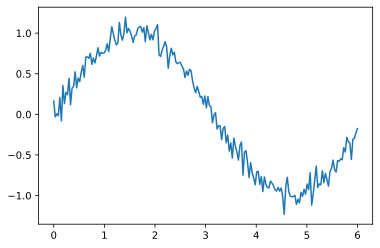

In [47]:
plt.plot(X, y)
plt.show()

## Building the model

We will create two models - one with regular decision trees, and another one with linear ones.
> The `linear_tree` argument for some reason enters the `Dataset`object, not the train one; hence, we need to define two datasets.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

train_data_linear = lgb.Dataset(X_train, label=y_train,
                        params={
                            'linear_tree': True
                        })

train_data_normal = lgb.Dataset(X_train, label=y_train)

For the regular LightGBM API, one must pass a `params` object:

In [49]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 30,
    "learning_rate": 0.1,
    "verbosity": -1
}

model_linear = lgb.train(params, train_data_linear)
model_normal = lgb.train(params, train_data_normal)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [50]:
y_pred_linear = model_linear.predict(X_test, num_iteration=model_linear.best_iteration)
y_pred_normal = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)

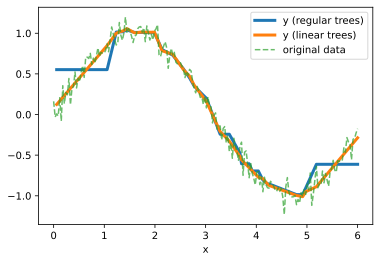

In [51]:
# plotting results
df = pd.DataFrame(X_test, columns=['x'])
df['y (regular trees)'] = y_pred_normal
df['y (linear trees)'] = y_pred_linear
df.sort_values('x').set_index('x').plot(lw=3)
plt.plot(X, y, label='original data', alpha=0.7, linestyle='--')
plt.legend()
plt.show()

Assessing error:

In [52]:
from sklearn.metrics import mean_squared_error
print(f"Linear trees error: {round(mean_squared_error(y_test, y_pred_linear),3)}")
print(f"Normal trees error: {round(mean_squared_error(y_test, y_pred_normal),3)}")

Linear trees error: 0.011
Normal trees error: 0.044


In this particular case, with this choice of hyperparameters, the linear trees model performed better.

## What about extrapolation?

In [53]:
X_extrapol = np.linspace(-2, 8, 500)
X_extrapol = X_extrapol.reshape(X_extrapol.shape[0],1)

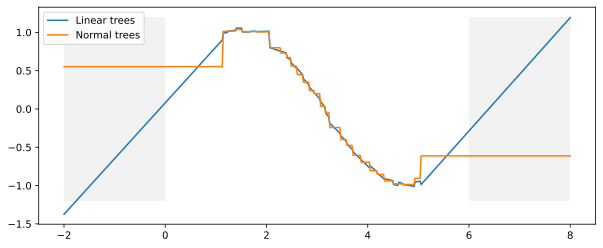

In [54]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(X_extrapol, model_linear.predict(X_extrapol, num_iteration=model_linear.best_iteration), label='Linear trees')
ax.plot(X_extrapol, model_normal.predict(X_extrapol, num_iteration=model_normal.best_iteration), label='Normal trees')
ax.legend()

ax.fill_between(np.linspace(-2,0), -1.2, 1.2, facecolor='gray', alpha=0.1)
ax.fill_between(np.linspace(6,8), -1.2, 1.2, facecolor='gray', alpha=0.1)

plt.show()

We see that exptrapolation happens exactly as we might have expected: linear trees extrapolate as linear functions (which thus diverge off) whereas usual trees stagnate. **None of the options is great**, and you must be careful on how you extrapolate to unseen data outside your training range. 